# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Thọ Tài
- MSSV: 23127255
- Lớp: 23CLC02

## Import các thư viện liên quan

In [88]:
from numba.core.cgutils import false_byte
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install Pillow
from matplotlib import pyplot as plt
import numpy as np

## Helper functions

In [91]:
from PIL import Image

def read_img(img_path: str):
	"""
	Read image from img_path

	Parameters
	----------
	img_path : str
		Path of image

	Returns
	-------
		Image (2D)
	"""
	return Image.open(img_path)

def show_img(img_2d: Image):
	"""
	Show image

	Parameters
	----------
	img_2d:
		Image (2D)
	"""
	plt.imshow(img_2d)
	plt.axis('off')
	plt.show()


def save_img(img_2d: Image, img_path: str):
	"""
	Save image to img_path

	Parameters
	----------
	img_2d:
		Image (2D)
	img_path : str
		Path of image
	"""
	img_2d.save(img_path)


def convert_img_to_1d(img_2d: Image):
	"""
	Convert 2D image to 1D image

	Parameters
	----------
	img_2d: <your type>
		Image (2D)

	Returns
	-------
		Image (1D)
	"""
	img_np = np.array(img_2d)
	return img_np.reshape(-1, 3)

BATCH_SIZE: int = 10000
EPSILON: float = 1e-5

def kmeans(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random', batch_size: int = BATCH_SIZE, epsilon: float = EPSILON) -> tuple[np.ndarray, np.ndarray]:
	"""
	K-Means algorithm
	Parameters
	----------
	:param img_1d: np.ndarray with shape=(height * width, num_channels) | Original (1D) image
	:param epsilon: Checking float number
	:param batch_size: Checking batch size for dot multiplication
	k_clusters : int
		Number of clusters
	max_iter : int
		Max iterator
	init_centroids : str, default='random'
		The method used to initialize the centroids for K-means clustering
		'random' --> Centroids are initialized with random values between 0 and 255 for each channel
		'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

	Returns
	-------
	centroids : np.ndarray with shape=(k_clusters, num_channels)
		Stores the color centroids for each cluster
	labels : np.ndarray with shape=(height * width, )
		Stores the cluster label for each pixel in the image
	"""
	n_pixels, n_channels = img_1d.shape
	img_1d = img_1d.astype(np.float32, copy=False)
	centroids: np.ndarray
	if init_centroids == 'random':
		centroids = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
	elif init_centroids == 'in_pixels':
		indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
		centroids = img_1d[indices].astype(np.float32)
	else:
		raise ValueError("Invalid init_centroids value")

	labels = np.zeros(n_pixels, dtype=np.int32)
	# compute distances without creating a bigger matrix: ||x - c||^2 = ||x||^2 + ||c||^2 - 2*x*c
	img_sq = np.sum(img_1d ** 2, axis=1)  # precompute ||x||^2
	for _ in range(max_iter):
		# TODO: maybe only square the valid centroids, may or may not have any significant effects?
		cent_sq = np.sum(centroids ** 2, axis=1)  # ||c||^2
		new_labels = np.zeros(n_pixels, dtype=np.int32)

		# Dot product costs memory a lot when with common image size, we spit the dot product by each cells to reduce the amount of memory used by the dot product
		# Previously, the code was:
		# cent_sq = np.sum(centroids ** 2, axis=1)[None, :] # ||c||^2
		# dot_product = img_1d @ centroids.T  # numpy matrix multiplication x * c
		# distances_sq = img_sq + cent_sq - 2 * dot_product
		# with dot product multiply two big and complex matrices, thus I split it out into chunk with input buffer size to save memory.
		for start in range(0, n_pixels, batch_size):
			end = min(start + batch_size, n_pixels)
			batch_img = img_1d[start:end]
			batch_img_sq = img_sq[start:end][:, None]

			dot_product = batch_img @ centroids.T
			distances_sq = batch_img_sq + cent_sq[None, :] - 2 * dot_product
			new_labels[start:end] = np.argmin(distances_sq, axis=1)

		# check for label convergence
		if np.array_equal(new_labels, labels):
			break

		labels[:] = new_labels

		sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
		counts = np.bincount(new_labels, minlength=k_clusters)
		np.add.at(sums, new_labels, img_1d)
		# only update valid centroids (only to avoid division by zero)
		valid = counts > 0
		centroids[valid] = sums[valid] / counts[valid][:, None]

		# check centroid convergence
		if np.all(np.abs(centroids[valid] - sums[valid] / counts[valid][:, None]) < epsilon): # maybe there is a better way to do this? EG: almost equal?
			break

	return centroids.astype(np.uint8), labels

def generate_2d_img(img_2d_shape, centroids, labels):
	"""
	Generate a 2D image based on K-means cluster centroids

	Parameters
	----------
	img_2d_shape : tuple (height, width, 3)
		Shape of image
	centroids : np.ndarray with shape=(k_clusters, num_channels)
		Store color centroids
	labels : np.ndarray with shape=(height * width, )
		Store label for pixels (cluster's index on which the pixel belongs)

	Returns
	-------
		New image (2D)
	"""

	height, width, channels = img_2d_shape
	clusters = centroids[labels]
	return Image.fromarray(clusters.reshape((height, width, channels)).astype(np.uint8))

def count_color(img: Image) -> int:
	img_1d = convert_img_to_1d(img)
	return np.unique(img_1d, axis=0).shape[0]

## Your tests

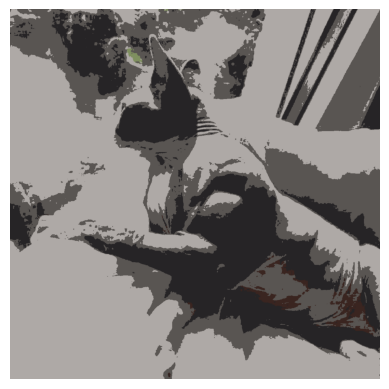

Current memory usage: 14.70 MB
Peak memory usage: 50.97 MB


In [113]:
import tracemalloc

tracemalloc.start()
img_path = 'cat.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans(img_1d, k_clusters=7, max_iter=25, init_centroids='random')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'random_7.png')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

## Main FUNCTION

In [114]:
def print_menu():
	print("\n==== Image Compression Menu ====")
	print("1. Compress an image: ")
	print("2. Display an image")
	print("3. Count number of unique colors in an image")
	print("0. Exit")
	print("================================")

def main():
	loop = True
	while loop:
		try:
			choice = int(input("Enter option: "))
		except ValueError:
			print("Invalid input. Please enter a number.")
			continue
		match choice:
			case 1:
				img_path = input("Enter image path: ")
				output_path = input("Enter output path: ")
				try:
					img = read_img(img_path)
				except FileNotFoundError:
					print("File not found.")
					continue
				img_1d = convert_img_to_1d(img)
				k_clusters = int(input("Enter number of clusters: "))
				max_iter = int(input("Enter maximum number of iterations: "))
				init_centroids = input("Enter init clusters method (random/in_pixels): ")
				try:
					img_centroids, img_labels = kmeans(img_1d, k_clusters, max_iter, init_centroids)
				except ValueError:
					print("Invalid init clusters. Please enter (random/in_pixels)!")
					continue
				print(f"Starting compression process...")
				compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
				save_img(compressed_img, output_path)
				print(f"Image compressed successfully and saved to ({output_path}).")
			case 2:
				img_path = input("Enter image path: ")
				try:
					img = read_img(img_path)
				except FileNotFoundError:
					print("File not found.")
					continue
				show_img(img)
			case 3:
				img_path = input("Enter image path: ")
				try:
					img = read_img(img_path)
				except FileNotFoundError:
					print("File not found.")
					continue
				print(f"Number of unique colors: {count_color(img)}")
			case 0:
				loop = False
main()

Number of unique colors: 48986
File not found.
Invalid input. Please enter a number.
Number of unique colors: 104
File not found.
Number of unique colors: 912


KeyboardInterrupt: Interrupted by user

# Debugging

In [ ]:
!python -m pip install scikit-learn
from sklearn.cluster import KMeans

def kmeans_sklearn(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random'):
    kmeans = KMeans(n_clusters=k_clusters, max_iter=max_iter, init=init_centroids, n_init=1)
    labels = kmeans.fit_predict(img_1d)
    centroids = kmeans.cluster_centers_
    return centroids.astype(np.uint8), labels